# Stock Visualization

This notebook contains loading the stock index from path or using Alphavantage as the source of index. After a ticker has been specified, the data is visualized with "Date" and "Closing Prices". 

Furthermore, two moving averages have been experimented with the data. The Standard Average and the Exponential Average and the mean squared error is tested for each.

In [1]:
# Importing the necessary libraries

import numpy as np # For csv file I/O
import pandas as pd # For dataframe manipulation
import os, json # For path input
import matplotlib.pyplot as plt # For data visualization

# For opening a url
from urllib.request import urlopen
from sklearn.preprocessing import MinMaxScaler

plt.style.use('dark_background')

In [2]:
data_source = input("Enter data source: ").lower()
ticker = input("Enter ticker: ")

if data_source == "alphavantage": 
    api_key = "OPD5IB91IVYQ4AAF" # Input your own API key. 
    url_string = "https://www.alphavantage.co/" \
                 "query?function=TIME_SERIES_DAILY&symbol=%s" \
                 "&outputsize=full&apikey=%s" % (ticker, data_source)
    file = 'stock-data-%s.csv' % ticker
    if not os.path.exists(file): 
        with urlopen(url_string) as url: 
            data = json.loads(url.read().decode())
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date', 'Low', 'High', 'Close', 'Open'])
            for k, v in data.items(): 
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(), float(v['3. low']), float(v['2. high']), 
                           float(v['4. close']), float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Saved to: %s' % file)
        df.to_csv(file)
    else:
        print("Already exists, loading CSV")
        df = pd.read_csv(file)
else: 
    df = pd.read_csv(os.path.join("/Users/Aksha/PycharmProjects/Stock-Prediction/Data/Stocks/%s.us.txt" % (ticker.lower()))
                    , delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close'])
    print('Loaded data from Kaggle repo.')

Enter data source: Kaggle
Enter ticker: AAL
Loaded data from Kaggle repo.


In [3]:
df = df.sort_values('Date')
df.head()

,Date,Open,High,Low,Close
0,2013-12-10,23.698,24.345,23.610,24.064
1,2013-12-11,24.607,26.288,24.539,25.139
2,2013-12-12,25.342,25.832,24.616,24.616
3,2013-12-13,24.771,25.437,24.684,25.369
4,2013-12-16,25.749,25.888,25.485,25.739


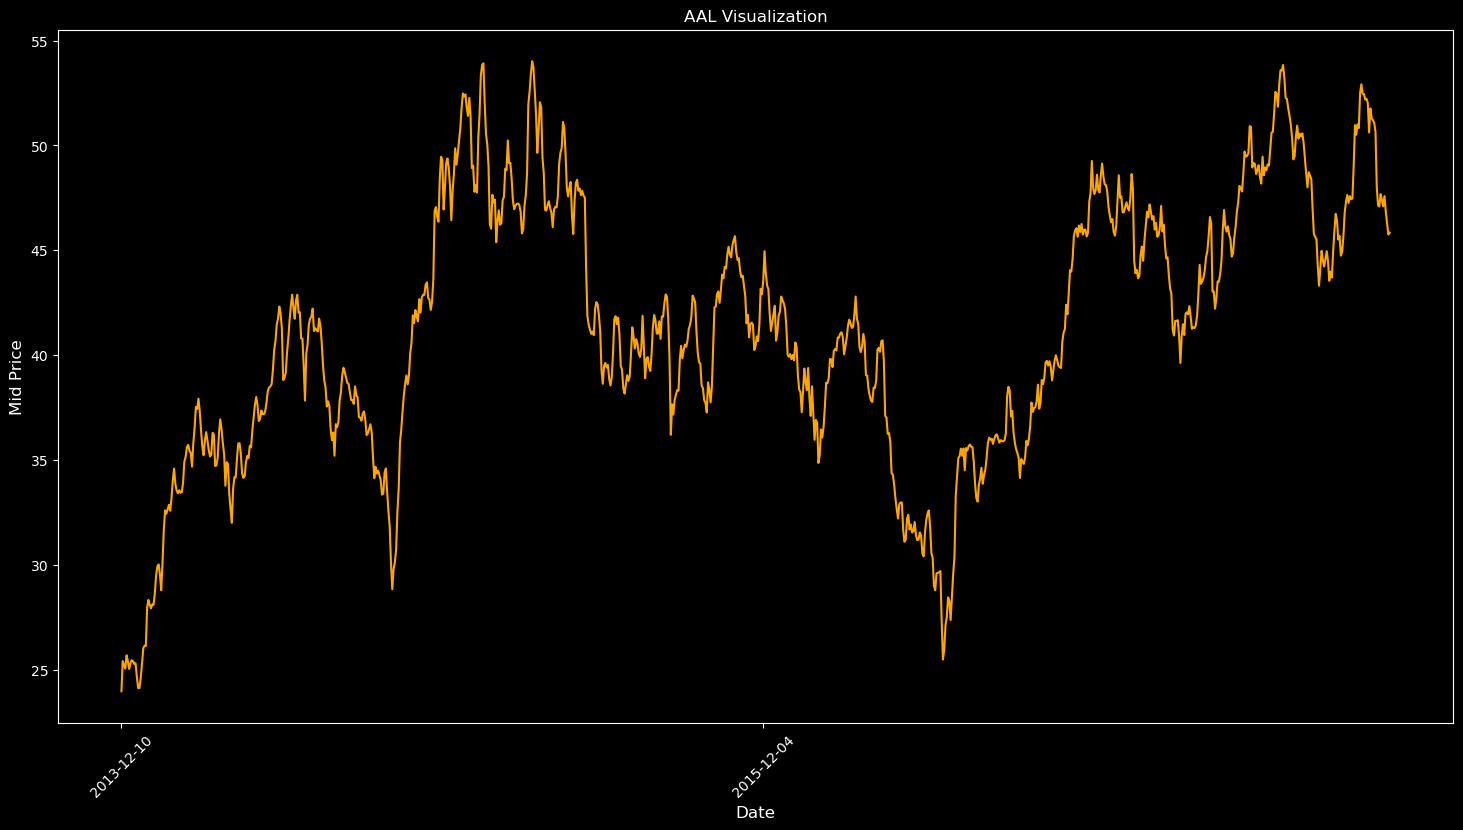

In [4]:
# Visualizing the index.

plt.figure(figsize=(18, 9))
plt.plot(range(df.shape[0]), (df['Low']+df['High'])/2.0, color='orange')
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mid Price', fontsize=12)
plt.title(f"{ticker} Visualization")
plt.show()

In [5]:
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = (high_prices + low_prices) / 2.0

In [6]:
index = int(0.7 * len(df))
train_data = mid_prices[:index]
test_data = mid_prices[index:]

In [7]:
# Scaling the data for further model implementation.
scaler = MinMaxScaler()
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

In [8]:
train_data = scaler.fit_transform(train_data)
test_data = scaler.fit_transform(test_data)

In [9]:
# Implemeting exponential moving average and testing RMSE. 
EMA = 0.0
gamma = 0.1
for idx in range(index): 
    EMA = gamma*train_data[idx] + (1-gamma) * EMA
    train_data[idx] = EMA

total_mid = np.concatenate([train_data, test_data], axis=0)

In [10]:
# Implementing standard moving average and testing RMSE. 
window_size = 100
size = train_data.size
std_avg_pred, std_avg_x, mse = [],[],[]

for idx in range(window_size, size): 
    if idx >= size: 
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[idx, 'Date']
    
    std_avg_pred.append(np.mean(train_data[idx-window_size:idx]))
    mse.append((std_avg_pred[-1]-train_data[idx]) ** 2)
    std_avg_x.append(date)
print("MSE for Standard Averaging: %.5f" % (0.5 * np.mean(mse)))

MSE for Standard Averaging: 0.01014


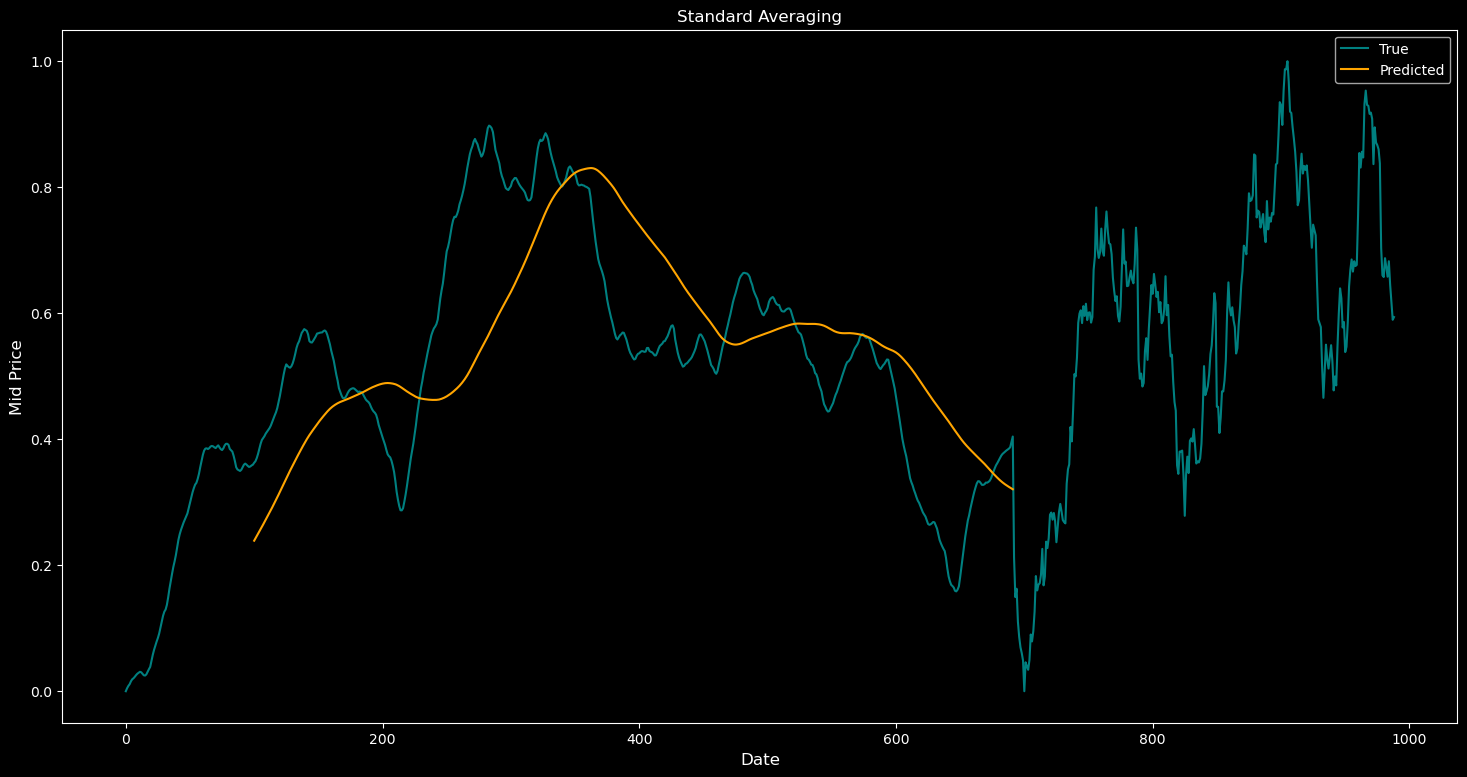

In [11]:
plt.figure(figsize=(18, 9))
plt.plot(range(df.shape[0]), total_mid, color='teal', label='True')
plt.plot(range(window_size, size), std_avg_pred, color='orange', label='Predicted')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mid Price', fontsize=12)
plt.title('Standard Averaging')
plt.legend()
plt.show()

In [12]:
window_size = 100 
size = train_data.size

run_avg_pred, run_avg_x, mse = [], [], []

run_mean = 0.0
run_avg_pred.append(run_mean)
decay = 0.5

for idx in range(1, size): 
    run_mean = run_mean*decay + (1.0-decay)*train_data[idx-1]
    run_avg_pred.append(run_mean)
    mse.append((run_avg_pred[-1]-train_data[idx]) ** 2)
    run_avg_x.append(date)
print("MSE for EMA Averaging: %.5f" % (0.5*np.mean(mse)))


MSE for EMA Averaging: 0.00009


C:\Users\Aksha\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


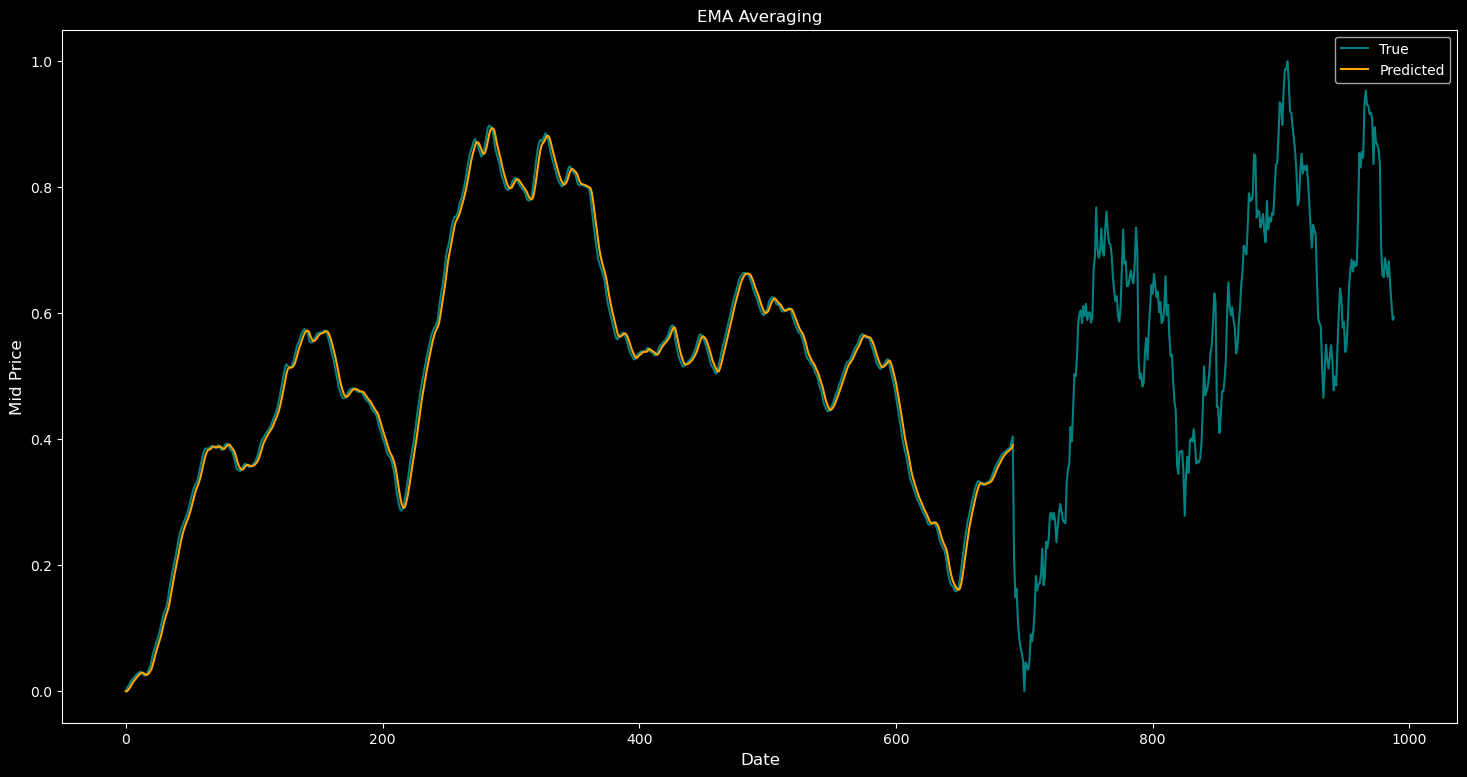

In [13]:
plt.figure(figsize=(18, 9))
plt.plot(range(df.shape[0]), total_mid, color='teal', label='True')
plt.plot(range(0, size), run_avg_pred, color='orange', label='Predicted')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mid Price', fontsize=12)
plt.title('EMA Averaging')
plt.legend()
plt.show()

Here, EMA is significantly more accurate than SMA.

For AAL index, 
1. RMSE(EMA): 0.00009
2. EMSE(SMA): 0.01014